In [2]:
import readpw; reload(readpw)
from readpw import Passwords
%matplotlib inline
rypw = Passwords('rockyou-withcount.txt.bz2')

In [3]:
freq_level = {}
import numpy as np
f = -np.log2(rypw._freq_list[np.nonzero(rypw._freq_list)]/rypw.totalf())
fceil = np.ceil(f)

[  0.                 -inf   1.           1.5849625    2.32192809
   5.5849625    7.20945337   8.51175265   9.77643303  10.7548875
  11.77684423  12.90407008  14.18835703  15.25654042  16.32551628
  17.405316    18.67371969  23.6958558 ]


/Users/rahul/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log2


24.957556552287688

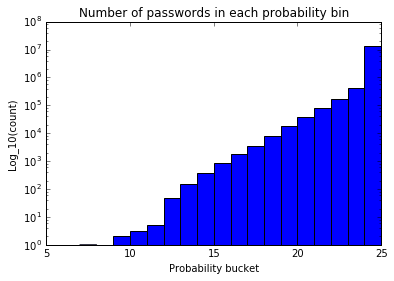

In [201]:
# np.histogram(fceil, bins=range(7,26))

plt.hist(fceil, bins=range(7,26), log=True)
plt.title("Number of passwords in each probability bin")
plt.xlabel("Probability bucket")
plt.ylabel("Log_10(count)")

# these are the counts of each probability bucket. The first bucket starts from 7, ends at 25.
print np.log2([       1,        0,        2,        3,        5,       48,
             148,      365,      877,     1728,     3509,     7665,
           18669,    39145,    82124,   173589,   418167, 13588245])

np.log2(rypw.totalf())

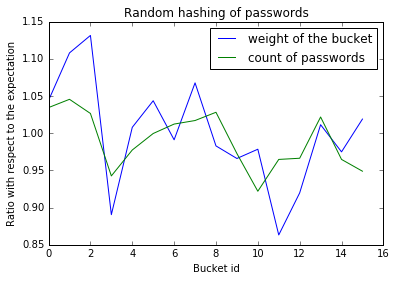

In [204]:
from hashlib import sha256
import os
sa = os.urandom(16)
def hash_(s):
    return sha256(bytes(s)+sa).hexdigest()[0]
bins = {hex(i)[-1:]: [0,0] for i in xrange(16)}

ignore_first = 100
total_pws = 10000 + ignore_first
for i, (pw,f) in enumerate(rypw.pws_in_order()):
    if i<ignore_first: continue
    bins[hash_(pw)][0] += f
    bins[hash_(pw)][1] += 1
    if i>total_pws: break
tot = float(sum(f for f,c in bins.values()))
expected = tot/16
cntmean = total_pws/16.0
x,y,z = zip(*sorted([(int(k, base=16),v/expected, c/cntmean) for k,(v,c) in bins.items()]))
plt.plot(x,y)
plt.plot(x,z)
plt.title("Random hashing of passwords")
plt.xlabel("Bucket id")
plt.ylabel("Ratio with respect to the expectation")
plt.legend(['weight of the bucket', 'count of passwords',])

# Point to note, that on many many runs the maximum and minimum bucket weight stays within,
# 15% daviation from the expected value.

In [62]:
brange = range(0, 101, 30)
qrange = range(1, 100, 10) + range(100, 10000, 100) + range(10000, 100000, 1000) + range(100000, 1000001, 10000)
sketchrange = range(0, 11, 1)
n = qrange[-1] * 2**sketchrange[-1]
ordered_fs = np.sort(rypw._freq_list)[::-1][:n]

def compute_black_list_succ(b, s):
    n_sketches = 2**s
    nfarr = np.concatenate([ordered_fs[:b]/n_sketches for _ in range(n_sketches)])
    nfarr = np.concatenate((nfarr, ordered_fs[b:qrange[-1]*n_sketches]))
    nfarr = np.sort(nfarr)[::-1]
    return np.array([nfarr[:q*n_sketches].sum()/rypw.totalf() for q in qrange])

from joblib import Parallel, delayed
p = Parallel(n_jobs=4)
func = delayed(compute_black_list_succ)
succ_rates = np.zeros(shape=(len(brange), len(sketchrange), len(qrange)))
l = []
for bi, b in enumerate(brange):
    for sj, s in enumerate(sketchrange):
        l.append(func(b, s))
res = p(l)
for bi, b in enumerate(brange):
    print b
    for sj, s in enumerate(sketchrange):
        succ_rates[bi, sj] = np.array(res[bi*len(sketchrange) + sj])

0
30
60
90


In [74]:
b, s = 10, 2
n_sketches = 2**s
q = 100
nfarr = np.concatenate([ordered_fs[:b]/n_sketches for _ in range(n_sketches)])
nfarr = np.concatenate((nfarr, ordered_fs[b:qrange[-1]*n_sketches]))
nfarr = np.sort(nfarr)[::-1]
nfarr[:q*n_sketches].sum()/rypw.totalf()

0.077561007873909418

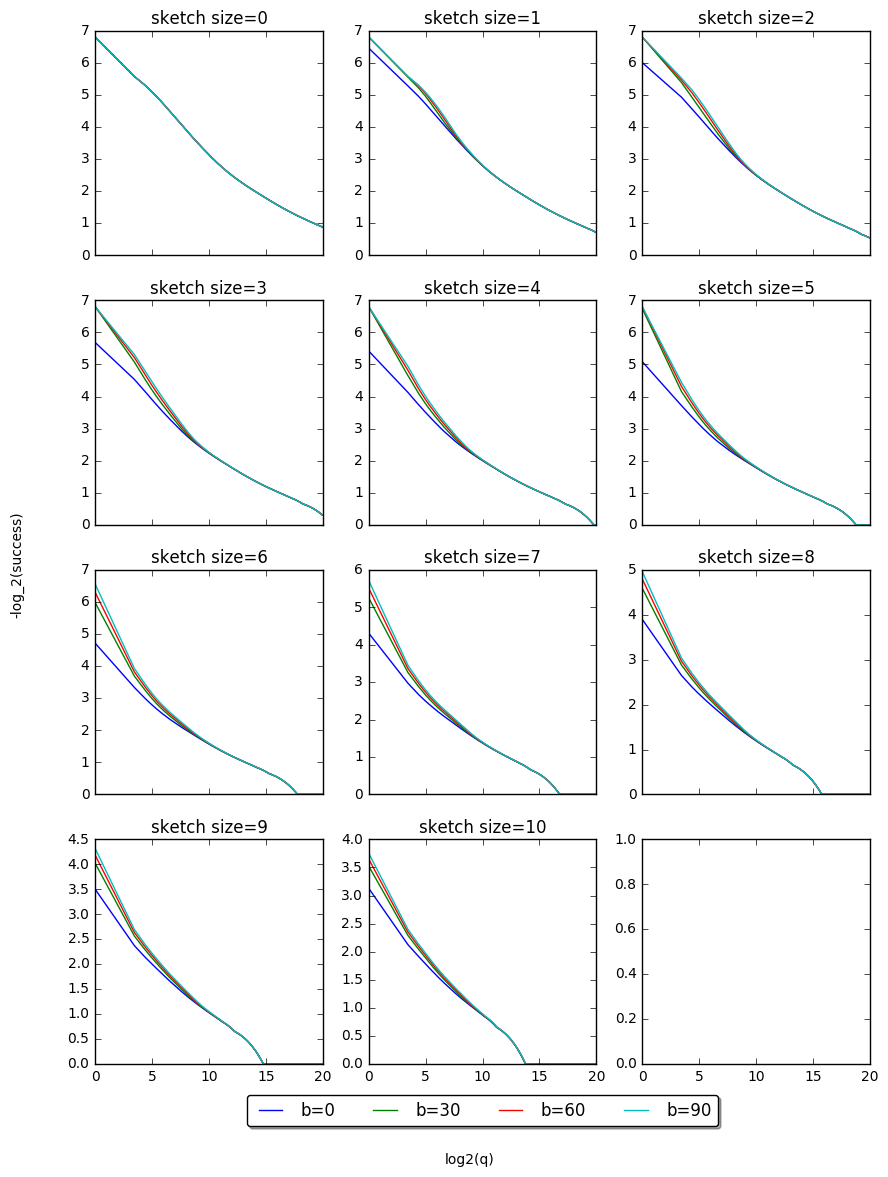

In [116]:
from matplotlib import pyplot as plt
# b, s
r = 4
c = 3
w = 10
f, ax = plt.subplots(r, c, sharex=True)
f.set_size_inches(w, w*r/float(c))
i,j = 0, 8

for j in range(len(sketchrange)):
    for i in range(len(brange)):
        ax[j/c, j%c].plot(np.log2(qrange), -np.log2(succ_rates[i,j]), label='b={}'.format(brange[i]))
        ax[j/c, j%c].set_title('sketch size={}'.format(sketchrange[j]))
f.text(0.5, 0.05, 'log2(q)', ha='center')
f.text(0.04, 0.5, '-log_2(success)', va='center', rotation='vertical')
ax[-1, -2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)